In [61]:
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
%matplotlib inline
from matplotlib.pyplot import style
import matplotlib.pyplot as plt

Замена

In [62]:
data = pd.read_csv('data/insurance.csv')
print(f'В наборе данных {data.shape[0]} записей')

В наборе данных 1338 записей


In [63]:
# преобразование каждого признака в числовой
sexUn = data['sex'].unique()
smokerUn = data['smoker'].unique()
regionUn = data['region'].unique()

for i in range(len(sexUn)):
    data['sex'] = data['sex'].replace(sexUn[i], i)

for i in range(len(smokerUn)):
    data['smoker'] = data['smoker'].replace(smokerUn[i], i)

for i in range(len(regionUn)):
    data['region'] = data['region'].replace(regionUn[i], i)

In [64]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,0,0,16884.92400
1,18,1,33.770,1,1,1,1725.55230
2,28,1,33.000,3,1,1,4449.46200
3,33,1,22.705,0,1,2,21984.47061
4,32,1,28.880,0,1,2,3866.85520


In [65]:
age = torch.tensor( data = data.age.values, dtype = torch.float )
bmi = torch.tensor( data = data.bmi.values, dtype = torch.float)
children = torch.tensor( data = data.children.values, dtype = torch.float)

sex = torch.tensor( data = data.sex.values, dtype = torch.float)
smoker = torch.tensor( data = data.smoker.values, dtype = torch.float)
region = torch.tensor( data = data.region.values, dtype = torch.float)

charges = torch.tensor( data = data.charges.values, dtype = torch.float )

In [66]:
data.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [67]:
X = torch.tensor(data.loc[:,['age','bmi','children', 'sex', 'smoker', 'region']].values)
y = torch.tensor(data.charges.values)
X.shape

torch.Size([1338, 6])

In [68]:
w = torch.rand(6, dtype=torch.double, requires_grad = True)
b = torch.rand(1, dtype=torch.double, requires_grad = True)
w, b

(tensor([0.2547, 0.4793, 0.8980, 0.5732, 0.6620, 0.9396], dtype=torch.float64,
        requires_grad=True),
 tensor([0.5800], dtype=torch.float64, requires_grad=True))

In [69]:
class MultipleRegression(nn.Module):

    def __init__(self, n_weight:int):
        super(MultipleRegression, self).__init__()
        self.w = torch.randn(size =(n_weight,1), dtype=torch.double,
                             requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, X:torch.Tensor):
        assert isinstance(X, torch.Tensor)
        prediction = X @ self.w + self.b
        return prediction

In [70]:
mymodel = MultipleRegression(n_weight = 6)
mymodel.b, mymodel.w

(tensor([-1.6365], requires_grad=True),
 tensor([[-1.7462e+00],
         [-2.6799e+00],
         [-3.7826e-01],
         [-2.2558e-03],
         [ 6.6134e-01],
         [-3.0685e-01]], dtype=torch.float64, requires_grad=True))

In [71]:
prediction = mymodel(X)

In [72]:
import torch.nn.functional as F
F.mse_loss(prediction, y.reshape(-1,1))

tensor(3.2698e+08, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [73]:
myoptimizer = torch.optim.SGD(params = [mymodel.b,mymodel.w], lr = 1e-9, momentum =0.9)
# myoptimizer = torch.optim.Adam([mymodel.b, mymodel.w], lr = 0.005)

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=4)

 22%|██▏       | 11017/50000 [00:01<00:06, 5793.72it/s]

epoch = 9999, loss = 135352311.99781337


 41%|████      | 20622/50000 [00:03<00:04, 6158.98it/s]

epoch = 19999, loss = 135118651.2539681


 62%|██████▏   | 31204/50000 [00:05<00:03, 6204.81it/s]

epoch = 29999, loss = 135031344.86006737


 82%|████████▏ | 41187/50000 [00:06<00:01, 6214.24it/s]

epoch = 39999, loss = 134994612.56797397


100%|██████████| 50000/50000 [00:08<00:00, 6105.96it/s]


epoch = 49999, loss = 134975402.2599754


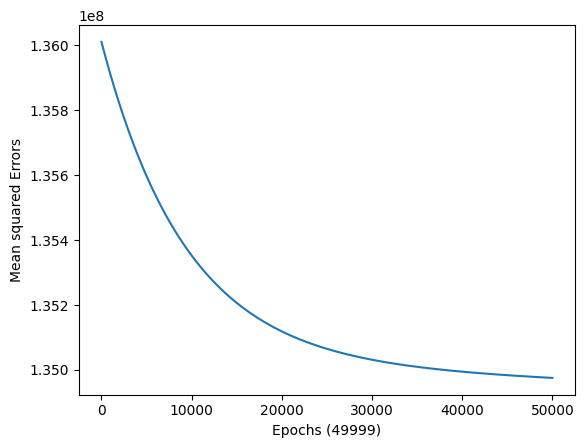

In [86]:
from sklearn.metrics import r2_score

r2data = []

myMSE = list()
for epoch in tqdm(range(50000)):
    myoptimizer.zero_grad()
    predicted = mymodel(x_train)
    loss = F.mse_loss(predicted, y_train.reshape(-1,1))
    myMSE.append(loss.detach())
    loss.backward()
    myoptimizer.step()
    if (epoch+1) % 10000 == 0:
        print(f'epoch = {epoch:02d}, loss = {loss}')

    with torch.no_grad():
        train_predictions = mymodel(x_train).squeeze().numpy()
        r2data.append(r2_score(y_train.numpy(), train_predictions))

plt.plot(myMSE);
plt.xlabel(f'Epochs ({epoch})'), plt.ylabel('Mean squared Errors');

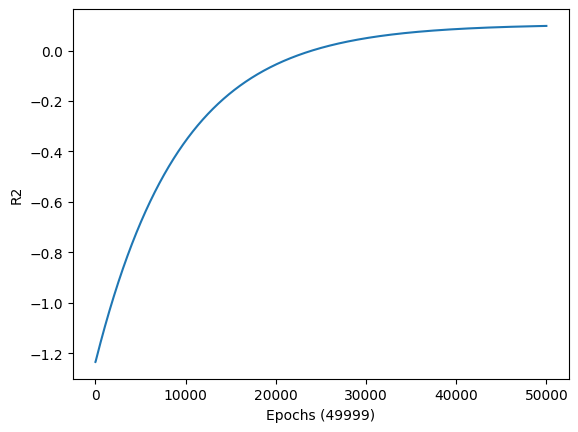

In [85]:
plt.plot(r2data)
plt.xlabel(f'Epochs ({epoch})'), plt.ylabel('R2');

In [76]:
from sklearn.metrics import r2_score
# Предсказание на обучающем наборе

mymodel.eval()
with torch.no_grad():
    train_predictions = mymodel(x_train).squeeze().numpy()

print(f"Train R2 score: {r2_score(y_train.numpy(), train_predictions)}")

# Предсказание на тестовом наборе
with torch.no_grad():
    test_predictions = mymodel(x_test).squeeze().numpy()
print(f"Test R2 score: {r2_score(y_test.numpy(), test_predictions)}")

Train R2 score: 0.0976597266622985
Test R2 score: 0.12164856161950433


In [77]:
mymodel.w, mymodel.b

(tensor([[202.9008],
         [151.1835],
         [  5.5783],
         [  2.7810],
         [  0.4266],
         [  6.4656]], dtype=torch.float64, requires_grad=True),
 tensor([3.0241], requires_grad=True))

Выполнить предсказание на данных:

In [79]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions =  model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [80]:
import random
exp = (random.randint(0, 1338))

input, target = X[exp], y[exp]
predict_single(input, target, mymodel)

Input: tensor([39.0000, 34.1000,  2.0000,  1.0000,  1.0000,  1.0000],
       dtype=torch.float64)
Target: tensor(23563.0162, dtype=torch.float64)
Prediction: tensor([13092.3422], dtype=torch.float64)
